## Autonomous RC

### RC architecture:
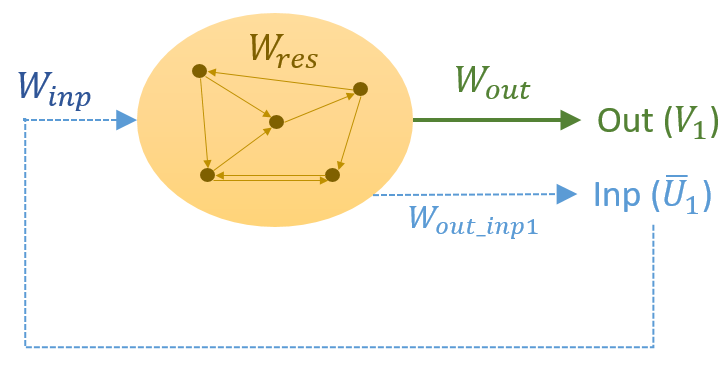

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot

import networkx as nx
from numpy.linalg import inv
import os
import random
from tqdm.notebook import tqdm, trange

In [2]:
def random_topology(nodes, edges, prng=None):
    # It would be easier to use a binomial random, but for small networks
    # deviations are not irrelevant
    prng = prng or np.random
    matrix = np.zeros(nodes**2)
    matrix[:edges] = np.random.random(edges)
    prng.shuffle(matrix)
    return matrix.reshape((nodes, nodes))

def fESN_control(N, Density, **kwargs):
    """Erdos-Renyi random network with the given number of nodes and the given
    proportion of existing edges with respect of the total number of possible
    edges
    """      
    M = int(Density*(N*(N-1)))  # Rounding
    RandTop = random_topology(nodes=N, edges=M)

    G = nx.DiGraph(RandTop)
    G.remove_nodes_from(list(nx.isolates(G)))
    GNet = nx.to_numpy_matrix(G)
    return G, GNet

def W_ress(k,n,eig_rho):
    # # ER network n*n and its radius is eig_rho
    prob = k/(n-1)
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            b = np.random.random()
            if (i != j) and (b < prob):
                W[i, j] = np.random.random()

    rad = max(abs(np.linalg.eigvals(W)))
    W_reservoirr = W*(eig_rho/rad)  

    return W_reservoirr

## Generate Reservoirs

In [4]:
import random 

# SaveDir = "D:/Work/Soma_Yadav/Simulations/python/Work-Plans/LSM_2022/Data/Networks/"

Na = 100; 

# density = 0.08 #0.07;
# Reps=1
# M = int(density*(Na*(Na-1)))
# G, GNet = fESN_control(Na, density)

k=10; eig_rho = 1.1
GNet = W_ress(k,Na,eig_rho)
G = nx.DiGraph(GNet)

N = GNet.shape[0]
Nodes_res=N

print(N, GNet.shape)

100 (100, 100)


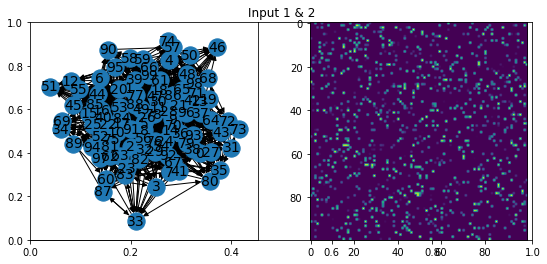

In [5]:
pos=nx.spring_layout(G)
labels = {}
for idx, node in enumerate(G.nodes()):
    labels[node] = idx    


fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 9
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size  
plt.title('Input 1 & 2')


ax1= subplot(1,2,1)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels, font_size=14)
# plt.title('The Recurrent part',size=20)

ax2 = subplot(1,2,2)
im=ax2.imshow(GNet)
# fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04) 

plt.show()

# Defining Input receiving nodes in Reservoir from each community
### 1. Inp1 to 1st nodes of each community


In [6]:
InpNodes = N

Inp1NodeList=random.sample(range(N), InpNodes)

Winp1 = np.zeros(N)#+1; 
Winp1[Inp1NodeList] = np.random.random(InpNodes)


print(Inp1NodeList, '\n\n', Winp1)

[39, 69, 66, 31, 75, 49, 86, 82, 77, 65, 4, 10, 56, 28, 44, 55, 85, 78, 74, 98, 90, 18, 48, 37, 30, 53, 58, 79, 45, 24, 27, 83, 35, 38, 92, 96, 70, 89, 16, 76, 67, 47, 9, 22, 88, 36, 29, 13, 71, 25, 93, 97, 21, 20, 12, 3, 41, 42, 43, 52, 54, 51, 94, 91, 80, 8, 19, 14, 26, 33, 72, 5, 7, 17, 84, 6, 11, 99, 62, 2, 63, 81, 64, 1, 15, 34, 60, 68, 59, 50, 57, 40, 46, 73, 61, 23, 0, 32, 87, 95] 

 [0.45921046 0.98989298 0.83201052 0.89893578 0.49490123 0.73175068
 0.70878939 0.73544122 0.72713271 0.89619882 0.64606492 0.11292373
 0.57378563 0.21539496 0.93107569 0.34001759 0.38613345 0.62249229
 0.39527483 0.06066218 0.20352304 0.18727316 0.99454875 0.70471683
 0.16009011 0.19174329 0.06558376 0.98207153 0.18106288 0.52907701
 0.2139982  0.83334613 0.05961771 0.76511573 0.10313526 0.09365276
 0.45648477 0.93444268 0.66281456 0.23116712 0.51514481 0.89264652
 0.54535189 0.19165245 0.44994474 0.68299682 0.43575109 0.45901463
 0.07538256 0.89322607 0.43300291 0.58198897 0.49707357 0.00213268
 0.

# Input 

2000


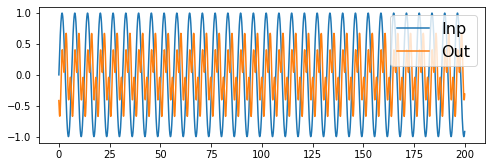

In [7]:
h=0.1
t = np.arange(0, 200, h)

#####Input##################
omega_i1=1; phi_i1=0
Inp1 = np.sin(omega_i1*t + phi_i1)
#####Output##################
omega_o1=1; phi_o1=4
Out1 = np.sin(omega_o1*t + phi_o1)**3 + 0.75*np.cos(omega_o1*t + 5)**3
############################

print(len(Inp1))

fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 8
fig_size[1] = 2.5
plt.plot(t,Inp1, label='Inp')
plt.plot(t,Out1, label='Out')
plt.legend(loc='upper right', fontsize=16)
plt.show()

# Reservoir

In [8]:
def Reservoir(GNet, Init, inval, Winp, N, alpha):
    Nodes_res = GNet.shape[0]; 
    Npts_U = len(inval)

    R = np.zeros([N, Npts_U])
    R[:,0] = Init
    
    #time loop
    for t in range(0, Npts_U-1):      
        R[:,t+1] = (1 - alpha)*np.asarray(R[:,t]) + alpha*np.tanh(np.dot(GNet, R[:,t].T) + Winp*inval[t] )
        
    return R

def Ridge_Regression(N, R, beta, V_train):
    W_out = np.dot(np.dot(V_train, R.T), np.linalg.inv((np.dot(R, R.T) + beta*np.identity(N))))
    return W_out


CPU times: total: 15.6 ms
Wall time: 20.9 ms
(100, 2000)


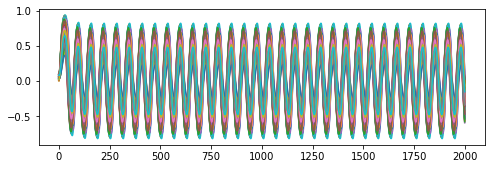

In [9]:
alpha = 0.15#0.1 #0.09999999999
Init = np.random.random(N)*0.1

%time Res = Reservoir(GNet, Init, Inp1, Winp1, N, alpha)
print(Res.shape)

plt.plot(Res.T)
plt.show()

# Train

In [10]:
Transients=0; beta = 5e-8
  
W_out = Ridge_Regression(N, Res[:,Transients:], beta, Out1[Transients:])
W_out_inp1 = Ridge_Regression(N, Res[:,Transients:], beta, Inp1[Transients:])

print(W_out.shape, W_out_inp1.shape)

(100,) (100,)


# Test

In [11]:
%time Res_test = Reservoir(GNet, Init, Inp1, Winp1, N, alpha)

Out_test = np.dot(W_out, Res_test)
Inp1_out_test = np.dot(W_out_inp1, Res_test)

print(Res_test.shape, Out_test.shape)

CPU times: total: 0 ns
Wall time: 20.3 ms
(100, 2000) (2000,)


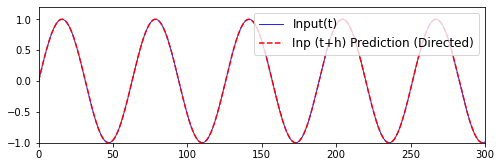

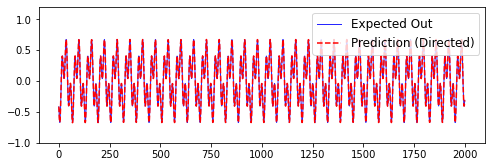

In [12]:
plt.plot(Inp1, c='blue', alpha=0.85, lw=1, label='Input(t)')
plt.plot(Inp1_out_test, c='red', ls='--', lw=1.5, label='Inp (t+h) Prediction (Directed)')
plt.ylim(-1,1.2)
plt.xlim(0, 300)
plt.legend(loc='upper right', fontsize=12)
plt.show()

plt.plot(Out1, c='blue', alpha=0.85, lw=1, label='Expected Out')
plt.plot(Out_test, c='red', ls='--', lw=1.5, label='Prediction (Directed)')
plt.ylim(-1,1.2)
plt.legend(loc='upper right', fontsize=12)
plt.show()

# Autonomous reservoir with initial transient run

In [13]:
def Autonomous_Reservoir(GNet, Init, T_Run, Winp, N, alpha, W_out_inp1, W_out):
        
    R = np.zeros([N, T_Run])
    R[:, 0] = Init
    Inp1_pred = np.zeros(T_Run); Out_pred = np.zeros(T_Run)
        
    #### time loop
    for t in range(0, T_Run-1):     
        R[:,t+1] = (1 - alpha)*np.asarray(R[:,t]) + alpha*np.tanh(np.dot(GNet, R[:,t].T) + Winp*Inp1_pred[t] )
        Inp1_pred[t+1] = np.dot(W_out_inp1, R[:,t+1])
        Out_pred[t+1] = np.dot(W_out, R[:,t+1])
        
    return R, Inp1_pred, Out_pred


(100, 4000) (4000,) (4000,)


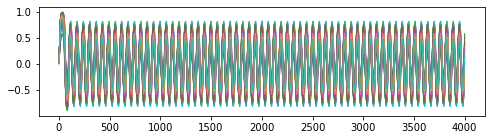

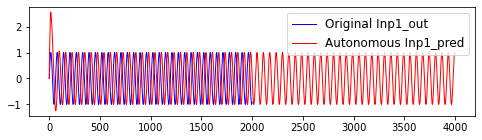

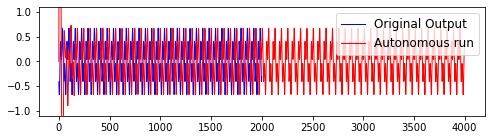

In [14]:
T_Run = int(400/h)
Init = np.random.random(N)*0.1

R_auto, Inp1_pred, Out_pred = Autonomous_Reservoir(GNet, Init, T_Run, Winp1, N, alpha, W_out_inp1, W_out)
print(R_auto.shape, Inp1_pred.shape, Out_pred.shape)


fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 8; fig_size[1] = 2

plt.plot(R_auto.T, ls="-",lw=0.75,alpha=1, label='Autonomous Run')
plt.show()

plt.plot(Inp1, lw=1, c='blue', ls="-", label='Original Inp1_out')
plt.plot(Inp1_pred, lw=1, c='red', ls="-", label='Autonomous Inp1_pred')
# plt.ylim(-1.1,1.1)
plt.legend(loc='upper right', fontsize=12)
plt.show()

plt.plot(Out1, lw=1, c='blue', ls="-", label='Original Output')
plt.plot(Out_pred, lw=1, c='red', ls="-", label='Autonomous run')
plt.ylim(-1.1,1.1)
# plt.xlim(0, 400)
plt.legend(loc='upper right', fontsize=12)
plt.show()

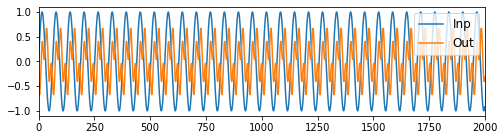

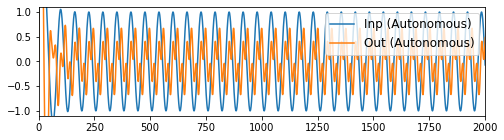

In [15]:
plt.plot(Inp1, label='Inp')
plt.plot(Out1, label='Out')
plt.legend(loc='upper right', fontsize=12)
plt.xlim(0,2000)
plt.show()

plt.plot(Inp1_pred, label='Inp (Autonomous)')
plt.plot(Out_pred, label='Out (Autonomous)')
plt.ylim(-1.1,1.1)
plt.xlim(0,2000)
plt.legend(loc='upper right', fontsize=12)
plt.show()

# Save Data

In [115]:
print(Inp1.shape, Out1.shape, Inp1_out_test.shape, Out_test.shape, Inp1_pred.shape, Out_pred.shape)

(2000,) (2000,) (2000,) (2000,) (4000,) (4000,)


In [119]:

def SaveData(SaveDir, Na, Inp, Out, InpFit, OutFit, InpAuto, OutAuto):
    np.save(os.path.join(SaveDir,'RC_N{:.2f}_InpOut_Original.npy'.format(Na)), np.array([Inp, Out])) 
    np.save(os.path.join(SaveDir,'RC_N{:.2f}_InpOut_Fit.npy'.format(Na)), np.array([InpFit, OutFit])) 
    np.save(os.path.join(SaveDir,'RC_N{:.2f}_InpOut_AutoPredict.npy'.format(Na)), np.array([InpAuto, OutAuto])) 
 

In [120]:
SaveDir = 'C:/Work/TU-Berlin/Projects/1.RC_from_Scratch/1.SinCosine/Data/2.AutoRC_SinCos/'

# SaveData(SaveDir, Na, Inp1, Out1, Inp1_out_test, Out_test, Inp1_pred, Out_pred)

In [121]:
DatP = np.load(os.path.join(SaveDir,'RC_N{:.2f}_InpOut_AutoPredict.npy'.format(Na))) 
DatP.shape

(2, 4000)

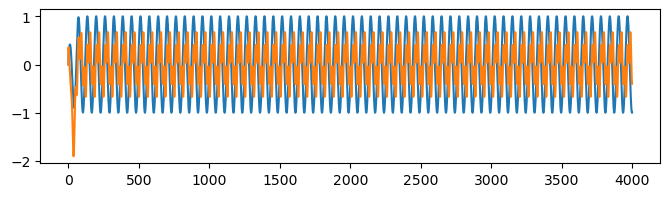

In [123]:
plt.plot(DatP.T)
plt.show()